In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crowdflower-search-relevance/train.csv.zip
/kaggle/input/crowdflower-search-relevance/sampleSubmission.csv.zip
/kaggle/input/crowdflower-search-relevance/test.csv.zip


In [2]:
import os
import wandb
from wandb.keras import WandbCallback
os.system('! wandb login be213aaff4ff14945d480abc18697d8664bba8c8')
training = pd.read_csv('/kaggle/input/crowdflower-search-relevance/train.csv.zip')
test = pd.read_csv('/kaggle/input/crowdflower-search-relevance/test.csv.zip')
test['target'] = np.NaN
training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test]) 
print(training.head())
print(test.head())
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
attribute_names = all_data.columns.tolist()
test_atts = test.columns.tolist()
all_dummies = pd.get_dummies(all_data[attribute_names])
test_dummies = pd.get_dummies(test[test_atts])  
X_train = all_dummies[all_data.train_test == 1].drop(['train_test'], axis=1)
for column in X_train.columns:
    mean_value = X_train[column].mean()
    X_train[column].fillna(mean_value, inplace=True)
X_check = X_train #for heatmap
X_train = X_train.drop(['relevance_variance'], axis=1)
X_backup = X_train
X_test = all_dummies[all_data.train_test == 0].drop(['train_test'], axis=1)
y_train = all_data[all_data.train_test==1].target
y_backup = y_train
X_test = X_test.drop(['relevance_variance'], axis=1)
for column in X_test.columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


   id                      query  \
0   1  bridal shower decorations   
1   2       led christmas lights   
2   4                  projector   
3   5                  wine rack   
4   7                 light bulb   

                                       product_title  \
0        Accent Pillow with Heart Design - Red/Black   
1  Set of 10 Battery Operated Multi LED Train Chr...   
2         ViewSonic Pro8200 DLP Multimedia Projector   
3  Concept Housewares WR-44526 Solid-Wood Ceiling...   
4  Wintergreen Lighting Christmas LED Light Bulb ...   

                                 product_description  median_relevance  \
0  Red satin accent pillow embroidered with a hea...                 1   
1  Set of 10 Battery Operated Train Christmas Lig...                 4   
2                                                NaN                 4   
3  Like a silent and sturdy tree, the Southern En...                 4   
4  WTGR1011\nFeatures\nNickel base, 60,000 averag...                 2   

 

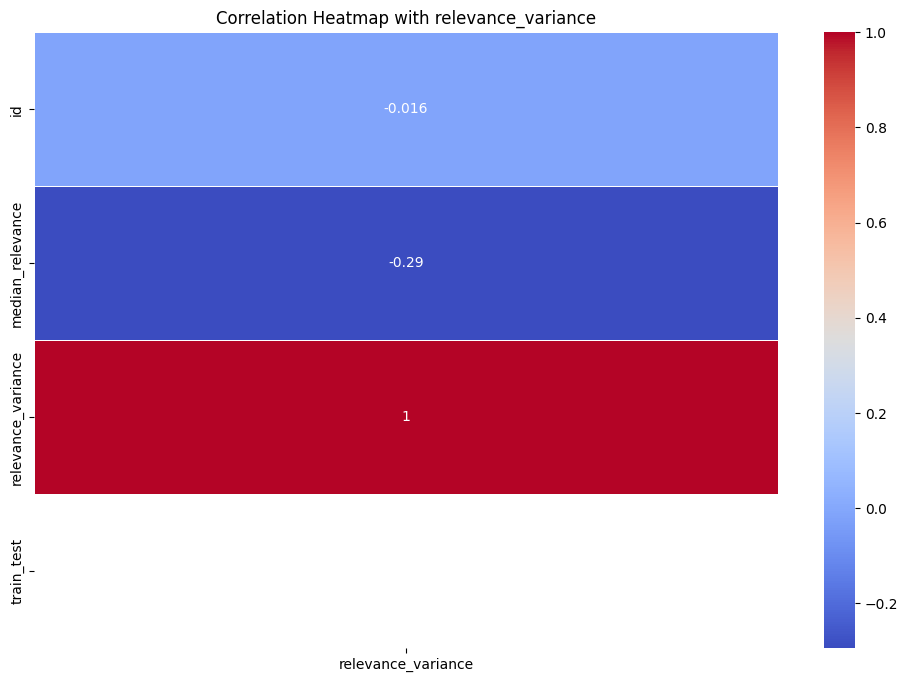

In [3]:
import matplotlib.pyplot as plt

target_variable = 'relevance_variance'
numeric_data = training.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[[target_variable]], annot=True, cmap='coolwarm', linewidths=.5)

plt.title(f'Correlation Heatmap with {target_variable}')
plt.show()

#due to the lack of numerical values, these types of visualization provide little information

In [ ]:
'''target_variable = 'relevance_variance'
correlations = X_train.corr()[target_column]
correlations = correlations.drop(target_variable)
# Filter features with a correlation of at least 0.4 or -0.4
significant_features = correlations[(correlations >= 0.1) | (correlations <= -0.1)]
significant_features_index = correlations[(correlations >= 0.1) | (correlations <= -0.1)].index
print(significant_features)
print(significant_features_index)

plt.figure(figsize=(10, 6))
sns.barplot(x=significant_features.values, y=significant_features.index)
plt.title(f'Features Correlating at least 0.1 or -0.1 with {target_column}')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.show()'''

In [ ]:
full_dataset = pd.concat([X_train, y_train], axis=1)

# Create a bar plot for each binary feature
plt.figure(figsize=(16, 8))
correlations = {}

for column in X_train.columns:
    if X_train[column].nunique() == 2:  # Check if the feature is binary
        plt.subplot(1, 2, 1)
        sns.countplot(x=column, data=full_dataset)
        plt.title(f'Prevalence of {column} being 1')

        plt.subplot(1, 2, 2)
        correlation = full_dataset[column].corr(y_train)
        sns.barplot(x=[column], y=[correlation])
        correlations[column] = correlation

plt.show()

# Display correlation values
print("Correlation with the target variable:")
for feature, correlation in correlations.items():
    print(f"{feature}: {correlation:.2f}")

In [ ]:
attribute_names = X_train.columns.tolist()
print(attribute_names)